#  Making student loans less burdensome
Team: Sunrockets
Vishal Patel (vpate83@uic.edu), Rishabh Manne (rmann20@uic.edu), Akhil Inampudi (ainam2@uic.edu), Sravani Bhamidipaty (sbham3@uic.edu)
Github Link: https://github.com/orgs/uic-cs418/teams/sunrockets

## Dataset (https://catalog.data.gov/dataset/national-student-loan-data-system-722b0)

<b>Scope</b>: Our analysis delved into dataset from the National Student Loan Data System, encompassing over 4,000 types of schools classified by state, school type, loan type, disbursement amount, and total loans disbursed. We narrowed our focus by excluding data from proprietary schools due to their for-profit nature.<br>
<b>Pre-processing</b>: We performed pre-processing steps, by only choosing private and public school data. In our Machine Learning analysis, we only focused on two types of loans Subsidized and Unsubsidized loans because the other two loans has lots of NaN values, which was also not enough data.<br>
<b>Additional Data Sets</b>: One dataset had the inflation increase from 2007 to 2022, while the other depicted the rise in national student debt over the same period.<br>
<b>Analysis Approach</b>: We adjusted tables and calculated year-to-year percentage increases that showed patterns in the nationwide student debt.<br>
<b>Initial Findings</b>: We observed a significant variance in disbursed amounts between private and public schools. Furthermore, a compelling correlation emerged between inflation rates and national student loan debt.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def process_cpi_data(file_path):
    df_cpi = pd.read_csv(file_path)
    december_data = df_cpi.iloc[11::12]
    cpi_december = december_data[['DATE', 'USACPIALLMINMEI']].copy()
    cpi_december['DATE'] = pd.to_datetime(cpi_december['DATE']).dt.year
    cpi_december.columns = ['Year', 'CPI']
    cpi_2007 = cpi_december[cpi_december['Year'] == 2007].iloc[0]['CPI']
    cpi_december['CPI Percent Increase from 2007'] = ((cpi_december['CPI'] - cpi_2007) / cpi_2007) * 100
    cpi_december = cpi_december[cpi_december['Year'] >= 2007]
    cpi_december.drop('CPI', axis=1, inplace=True)
    cpi_december.reset_index(drop=True, inplace=True)
    return cpi_december

def process_student_debt_data(file_path):
    df_debt = pd.read_csv(file_path)
    debt_2007 = df_debt[df_debt['Year'] == 2007]['Student loan debt ($ trillion)'].values[0]
    df_debt['Student Debt Percent Increase from 2007'] = ((df_debt['Student loan debt ($ trillion)'] - debt_2007) / debt_2007) * 100
    new_df_debt = df_debt[['Year', 'Student Debt Percent Increase from 2007']]
    return new_df_debt

In [3]:
cpi_december = process_cpi_data('InflationCPI2.csv')
student_debt = process_student_debt_data('student_debt.csv')
combined_df = cpi_december.merge(student_debt, on="Year", how="inner")
combined_df.columns = ['Year', 'CPI Percent Increase from 2007', 'Student Debt Percent Increase from 2007']
combined_df.head()

,Year,CPI Percent Increase from 2007,Student Debt Percent Increase from 2007
0,2007,0.000000,0.000000
1,2008,0.091413,15.254237
2,2009,2.815232,30.508475
3,2010,4.353063,45.762712
4,2011,7.444438,62.711864


In [4]:
def process_cumulative_data(file_path):
    cumulative_df = pd.read_csv(file_path, skiprows=5)
    cumulative_df = cumulative_df[['State', 'Zip Code', 'School Type', '# of Disbursements', '$ of Disbursements', '# of Disbursements.1', '$ of Disbursements.1','# of Disbursements.2', '$ of Disbursements.2', '# of Disbursements.3','$ of Disbursements.3']]
    return cumulative_df

In [5]:
cumulative_df = process_cumulative_data('Award Year Cumulative Activity.csv')
cumulative_df.head()

,State,Zip Code,School Type,# of Disbursements,$ of Disbursements,# of Disbursements.1,$ of Disbursements.1,# of Disbursements.2,$ of Disbursements.2,# of Disbursements.3,$ of Disbursements.3
0,AK,995084672,PRIVATE,292,830513,271,896614,35,192181,5,34865
1,AK,997757500,PUBLIC,1455,3290699,1542,4472224,40,138160,4,28988
2,AK,998018680,PUBLIC,439,1044946,478,1558767,8,44024,0,0
3,AK,995088050,PUBLIC,3045,6440086,3435,10219443,125,645683,11,24063
4,AK,995071033,PROPRIETARY,38,52178,37,67331,0,0,0,0


## Machine Learning Technique

In [6]:
cumulative_df = pd.read_csv('Award Year Cumulative Activity.csv', skiprows=5)
regions = {
    'West': ['WA', 'OR', 'CA', 'AK', 'NV', 'AZ', 'UT', 'CO', 'NM', 'ID', 'MT', 'WY'],
    'Midwest': ['ND', 'SD', 'NE', 'KS', 'MO', 'IA', 'MN', 'WI', 'IL', 'IN', 'OH', 'MI'],
    'South': ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL', 'SC', 'NC', 'TN', 'KY', 'VA', 'WV', 'MD', 'DE'],
    'Northeast': ['PA', 'NJ', 'NY', 'VT', 'NH', 'ME', 'RI', 'MA']} # creating a dictionary, by which each state is going to be classified by

def region_classification(state):  # classifying each state into their respective region
    for region, states in regions.items():
        if state in states:
            return region
    return None

cumulative_df['Region'] = cumulative_df['State'].apply(region_classification) # further classifying into public vs private schools
private_schools = cumulative_df[cumulative_df['School Type'] == 'PRIVATE']
public_schools = cumulative_df[cumulative_df['School Type'] == 'PUBLIC']

def group(schools):
    return schools.groupby(['Region', 'School Type']).agg({
        '# of Disbursements': 'sum','$ of Disbursements': 'sum'}).reset_index() # calculating the sum based on the two input features of region and school type

In [7]:
private_schools_total = group(private_schools)
public_schools_total = group(public_schools)

def average_disbursement(average_per_person):
    average_per_person['Disbursements Ratio'] = average_per_person['$ of Disbursements'] / average_per_person['# of Disbursements']
    return average_per_person

private_schools_total = average_disbursement(private_schools_total)
public_schools_total = average_disbursement(public_schools_total)
national_private_average_subsidized = cumulative_df[cumulative_df['School Type'] == 'PRIVATE']['$ of Disbursements'].sum() / cumulative_df[cumulative_df['School Type'] == 'PRIVATE']['# of Disbursements'].sum()
national_public_average_subsidized = cumulative_df[cumulative_df['School Type'] == 'PUBLIC']['$ of Disbursements'].sum() / cumulative_df[cumulative_df['School Type'] == 'PUBLIC']['# of Disbursements'].sum()
national_private_average_unsubsidized = cumulative_df[cumulative_df['School Type'] == 'PRIVATE']['$ of Disbursements.1'].sum() / cumulative_df[cumulative_df['School Type'] == 'PRIVATE']['# of Disbursements.1'].sum()
national_public_average_unsubsidized = cumulative_df[cumulative_df['School Type'] == 'PUBLIC']['$ of Disbursements.1'].sum() / cumulative_df[cumulative_df['School Type'] == 'PUBLIC']['# of Disbursements.1'].sum()

In [8]:
def clustering(df, national_avg_subsidized, national_avg_unsubsidized):
    kmeans = KMeans(n_clusters=2, random_state=42)
    df['Cluster'] = kmeans.fit_predict(df[['Disbursements Ratio']])
    df['Cluster_Label'] = df['Cluster'].apply(lambda x: 'Subsidized' if x == 0 else 'Unsubsidized')
    df['National_Average_Subsidized'] = (df['Disbursements Ratio'] > national_avg_subsidized) 
    df['National_Average_Unsubsidized'] = (df['Disbursements Ratio'] > national_avg_unsubsidized)
    return df
private_schools_average = clustering(private_schools_total, national_private_average_subsidized, national_private_average_unsubsidized)
public_schools_average = clustering(public_schools_total, national_public_average_subsidized, national_public_average_unsubsidized)

In [9]:
print("Private Schools:")
print(private_schools_total[['Region', 'School Type', 'Cluster_Label', 'National_Average_Subsidized', 'National_Average_Unsubsidized']].to_string(index=False))
print("\nPublic Schools:")
print(public_schools_total[['Region', 'School Type', 'Cluster_Label', 'National_Average_Subsidized', 'National_Average_Unsubsidized']].to_string(index=False))
print("\n")
print("National Average Disbursements per Person (Subsidized Loans for Private Schools): ${:.2f}".format(national_private_average_subsidized))
print("National Average Disbursements per Person (Unsubsidized Loans for Private Schools): ${:.2f}".format(national_private_average_unsubsidized))
print("National Average Disbursements per Person (Subsidized Loans for Public Schools): ${:.2f}".format(national_public_average_subsidized))
print("National Average Disbursements per Person (Unsubsidized Loans for Public Schools): ${:.2f}".format(national_public_average_unsubsidized))

Private Schools:
   Region School Type Cluster_Label  National_Average_Subsidized  National_Average_Unsubsidized
  Midwest     PRIVATE    Subsidized                        False                          False
Northeast     PRIVATE  Unsubsidized                         True                          False
    South     PRIVATE    Subsidized                        False                          False
     West     PRIVATE  Unsubsidized                         True                          False

Public Schools:
   Region School Type Cluster_Label  National_Average_Subsidized  National_Average_Unsubsidized
  Midwest      PUBLIC  Unsubsidized                        False                          False
Northeast      PUBLIC    Subsidized                         True                          False
    South      PUBLIC    Subsidized                         True                          False
     West      PUBLIC    Subsidized                        False                          False


Nati

<b>Objective</b>: Automatically divide schools into clusters based on School Type, Region, and Disbursement Ratio using unsupervised learning techniques to identify similarities in loan disbursement patterns.

<b>Process (Features)</b>:<br>
<b>Region</b>: The geographic location of the school (Northeast, Midwest, South, West).<br>
<b>School Type</b>: Whether the school is public or private.<br>
<b>Disbursement Ratio</b>: The ratio of dollars disbursed to the number of disbursements made by the school.<br>

<b>Output</b>: The K-means clustering algorithm is applied to partition school data into two clusters based on similarity in loan disbursement patterns, with subsequent labeling of clusters as "Subsidized" or "Unsubsidized" according to their disbursement characteristics.

<b>Comparison with National Averages for additional context</b>: Each school's Disbursement Ratio is compared with the national average for both subsidized and unsubsidized loans. This step helps in further categorizing schools based on how their disbursement ratios compare to the national averages.

<b>Findings</b>:
- In the Midwest and South regions, students going to private schools are more likely to get "Subsidized" loans.
- In all regions except for the Midwest, students going to public schools are more likely to get "Unsubsidized" loans.
- For Northeast and West regions, the "National_Average_subsidized" column indicates that the disbursements ratio for private schools is above the national average for subsidized loans.
- For Northeast and South regions, the "National_Average_subsidized" column indicates that the disbursements ratio for public schools is above the national average for subsidized loans.
- For all regions, the "National_Average_Label_unsubsidized" column indicates that the disbursements ratio for private and public schools is below the national average for unsubsidized loans because everyone has the option to take these loans.

## Statistical Analysis Technique

In [10]:
def z_test():
    df2 = cumulative_df[['School Type', '$ of Disbursements']]
    df2 = df2[df2['School Type'].isin(['PRIVATE', 'PUBLIC'])]
    public_universities = df2[df2['School Type'] == 'PUBLIC']['$ of Disbursements']
    private_universities = df2[df2['School Type'] == 'PRIVATE']['$ of Disbursements']
    mean0 = np.mean(public_universities)  # Mean of public universities amount of loan disbursed
    mean1 = np.mean(private_universities)  # Mean of private universities amount of loan disbursed
    std0 = np.std(public_universities)  # Standard deviation of public universities amount of loan disbursed
    std1 = np.std(private_universities)  # Standard deviation of private universities amount of loan disbursed
    pooled_std = np.sqrt((std0**2 / len(public_universities)) + (std1**2 / len(private_universities)))
    z_stat = (mean0 - mean1) / pooled_std
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    print("z-statistic:", z_stat)
    print("p-value:", p_value)

In [11]:
z_test() # calculates the mean and standard deviations of public vs. private universities separately and then prints the statistics

z-statistic: 5.277942540714894
p-value: 1.3064241355387196e-07


Let $μ_{0}$ = The mean amount of loan disbursements for public universities in dollars<br>
Let $μ_{1}$ = The mean amount of loan disbursements for private universities in dollars

Null hypothesis $H_{0}$: $μ_{0}$ = $μ_{1}$<br>
Alternative hypothesis $H_{A}$: $μ_{0}$ ≠ $μ_{1}$

Because the p-value of 1.3064241355387196e-07 ≈ 0 ≤ α = 0.05, we reject the null hypothesis that the mean amount of loan disbursements for public universities in dollars is equal to the mean amount of loan disbursements for private universities in dollars. There is convincing statistical evidence that the mean amount of loan disbursements for public universities in dollars is not equal to the mean amount of loan disbursements for private universities in dollars.<br>
While the z-test resulted in rejecting the null hypothesis that the mean amount of loan disbursements for public universities is equal to the mean amount of loan disbursements for private universities, it's important to recognize that there is a small possibility of a Type I error. A Type I error occurs when we incorrectly reject a true null hypothesis.


## Visualization 1: Percent Increase in CPI and Student Debt from 2007

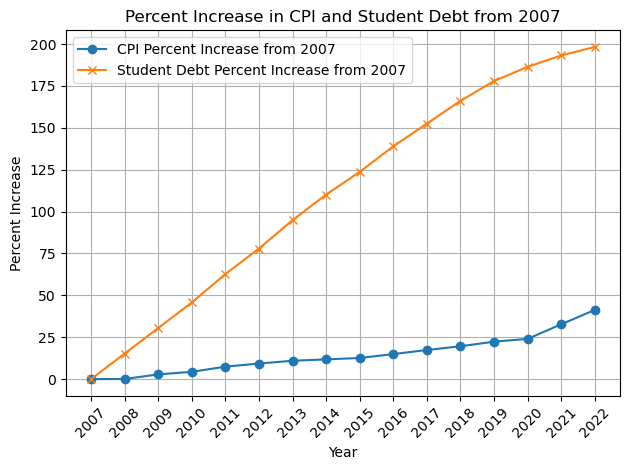

In [12]:
def visualization1():
    plt.plot(combined_df['Year'], combined_df['CPI Percent Increase from 2007'], label='CPI Percent Increase from 2007', marker='o')
    plt.plot(combined_df['Year'], combined_df['Student Debt Percent Increase from 2007'], label='Student Debt Percent Increase from 2007', marker='x')
    plt.title('Percent Increase in CPI and Student Debt from 2007')
    plt.xlabel('Year')
    plt.ylabel('Percent Increase')
    plt.legend()
    plt.grid(True)
    plt.xticks(combined_df['Year'], rotation=45)
    plt.tight_layout()
    plt.show()
visualization1()

This line chart shows the percentage debt increase in college compared to the percentage increase in inflation calculated with the Consumer Price Index, CPI). This line graph illustrates a striking difference between the two. While inflation has risen steadily, the increase in college debt has skyrocketed at a much faster rate. This shows a growing crisis of college affordability and hence require policy interventions. Clearly, it brings out the issue of the government reducing the interest rates of the loans offered to students so that they can make repayments when they come out of college. It also calls for education institutions to review their fees downwards to ensure that higher education is made readily accessible.

## Visualization 2: Total Amount of Loans Originated by School Type for each FFEL Category (in Billions USD)

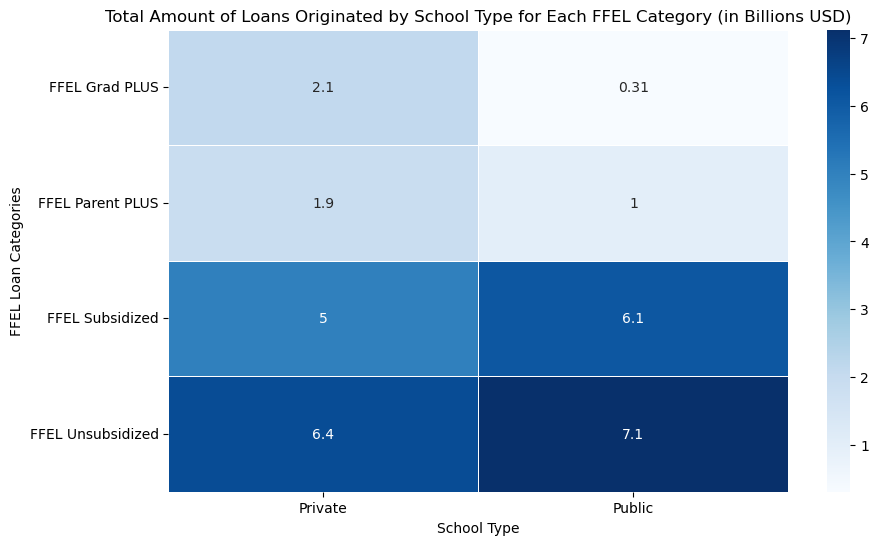

In [13]:
def visualization2():
    cumulative_df = pd.read_csv('Award Year Cumulative Activity.csv', skiprows=5)
    private_schools = cumulative_df[cumulative_df.iloc[:, 4] == 'PRIVATE']
    public_schools = cumulative_df[cumulative_df.iloc[:, 4] == 'PUBLIC']
    private_totals = {'FFEL Subsidized': private_schools.iloc[:, 7].sum(),'FFEL Unsubsidized': private_schools.iloc[:, 12].sum(),'FFEL Parent PLUS': private_schools.iloc[:, 17].sum(),'FFEL Grad PLUS': private_schools.iloc[:, 22].sum()}
    public_totals = {'FFEL Subsidized': public_schools.iloc[:, 7].sum(),'FFEL Unsubsidized': public_schools.iloc[:, 12].sum(),'FFEL Parent PLUS': public_schools.iloc[:, 17].sum(),'FFEL Grad PLUS': public_schools.iloc[:, 22].sum()}
    data = pd.DataFrame({'Category': list(private_totals.keys()) + list(public_totals.keys()),'School Type': ['Private'] * 4 + ['Public'] * 4,'Total Loans (USD)': list(private_totals.values()) + list(public_totals.values())})
    heatmap_data = data.pivot(index="Category", columns="School Type", values="Total Loans (USD)") / 1e9  # Convert to billions
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="Blues", linewidths=.5)
    plt.title('Total Amount of Loans Originated by School Type for Each FFEL Category (in Billions USD)')
    plt.xlabel('School Type')
    plt.ylabel('FFEL Loan Categories')
    plt.show()
visualization2()

This heat map shows the total dollar amount of loans by school type for the different Federal Family Education Loan (FFEL) loan categories, which are Subsidized, Unsubsidized, Parent PLUS, and Grad PLUS loans, they are plotted on the y-axis, while the x-axis shows the private and public school categories. Each FFEL category contains two cells which represent the loan amounts in billions of dollars for the private and public schools, respectively. The visualization displays that students who go to public schools take out more in loans for both Subsidized and Unsubsidized categories compared to private schools. However, for Parent PLUS and Grad PLUS loans, private schools are leading this category.

## Visualization 3: Total Amount of Loans per State

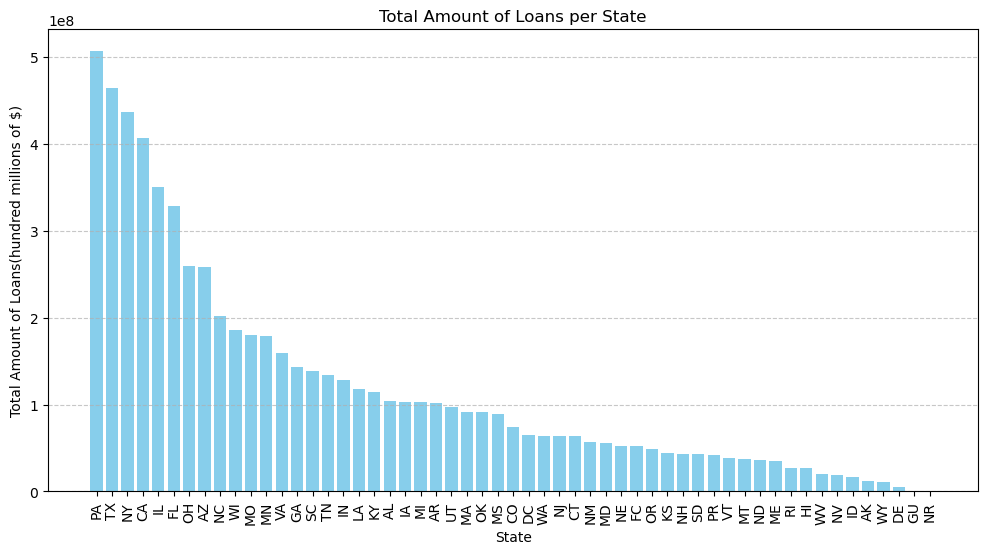

In [14]:
def visualization3():
    cumulative_df = pd.read_csv('Award Year Cumulative Activity.csv', skiprows=5)
    total_loans_per_state = cumulative_df.groupby('State')['$ of Disbursements'].sum().reset_index()
    total_loans_per_state = total_loans_per_state.sort_values(by='$ of Disbursements', ascending=False)
    plt.figure(figsize=(12, 6))
    plt.bar(total_loans_per_state['State'], total_loans_per_state['$ of Disbursements'], color='skyblue')
    plt.title('Total Amount of Loans per State')
    plt.xlabel('State')
    plt.ylabel('Total Amount of Loans(hundred millions of $)')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
visualization3()

The bar chart shows the total amount of loans disbursed per state regardless of whether a school is public or private. On the x-axis, each state is plotted with their respective state code and the on the y-axis, the total amount of loans disbursed in hundred millions of dollars are plotted. There is a significant disparity between the amount of loans in different states with Pennsylvania having the most amount of loans disbursed and Delaware having the least amount of loans disbursed.

## Results:

- There was more loan disbursement for public schools when it came to subsidized loans which reflects how there is a higher financial need for students in public schools compared to private schools.
- Private schools tend to have a higher disbursement ratio for unsubsidized loans compared to public schools, suggesting that students from wealthier backgrounds may opt for unsubsidized loans, especially if they have family support to manage the interest accumulation.
- Through the  K-means clustering, it was found that schools in the Northeast region disburse more subsidized loans than other regions regardless of whether the school is public or private, which can be advantageous for students attending schools in this region due to the interest-free nature of subsidized loans.
- The data highlights a significant disparity in loan disbursements between public and private schools, particularly regarding subsidized loans, indicating higher financial need in public schools. Thus, when prospective students are considering to make a loan, then should consider the region of their school, the type of the school, and the amount of loans currently given out for students (disbursement ratio). Moreover, the decision to take out loans should also be based on individual financial circumstances and future repayment plans.